In [1]:
! pip install -q lalsuite
# Install all required gravitational-wave tools properly
!pip install gwpy --no-cache-dir --quiet
! pip install -q pycbc

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries

In [4]:
# Load the strain data from the GWF file, specifying the channel
data = TimeSeries.read("challenge1.gwf", channel="H1:CHALLENGE1")

# Print basic info
print(f"Sampling rate: {data.sample_rate} Hz")
print(f"Duration: {data.duration} seconds")

Sampling rate: 4096.0 Hz Hz
Duration: 128.0 s seconds


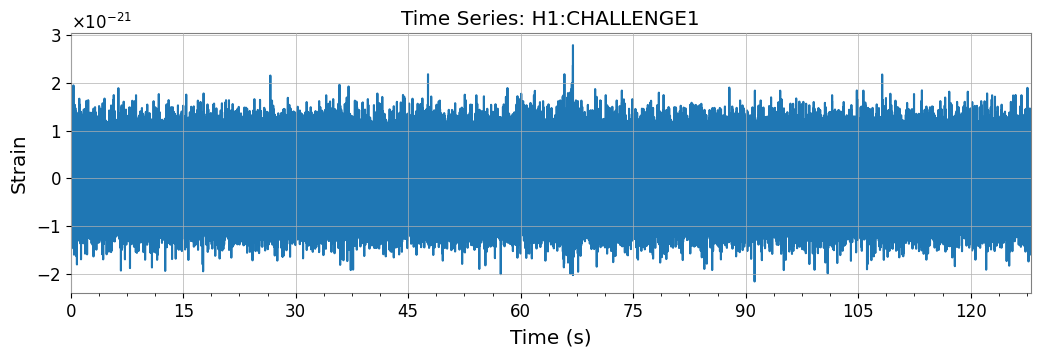

In [5]:
# Plot time-domain data
plot = data.plot()
plt.title("Time Series: H1:CHALLENGE1")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.grid(True)
plt.show()

In [9]:
# Find the time of peak amplitude
peak_time = data.times.value[np.argmax(abs(data.value))]
print(f"Estimated time of merger: {peak_time:.3f} seconds")

Estimated time of merger: 66.967 seconds


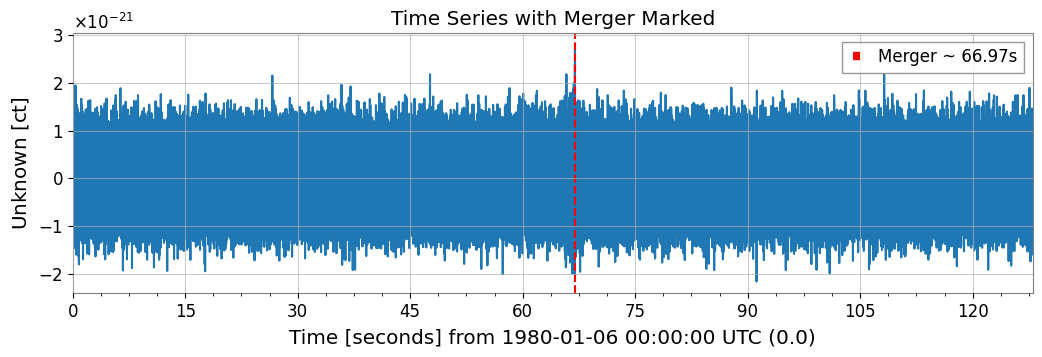

In [10]:
plot = data.plot()
plt.axvline(peak_time, color='red', linestyle='--', label=f"Merger ~ {peak_time:.2f}s")
plt.title("Time Series with Merger Marked")
plt.legend()
plt.show()

In [14]:
from gwpy.timeseries import TimeSeries

# Load the strain data from the GWF file
data = TimeSeries.read("challenge2.gwf", channel="H1:CHALLENGE2")

# Display metadata
print(f"Sampling rate: {data.sample_rate} Hz")
print(f"Duration: {data.duration} seconds")
print(f"Start time: {data.t0.value}")
print(f"End time: {(data.t0 +data.duration).value}")

Sampling rate: 4096.0 Hz Hz
Duration: 128.0 s seconds
Start time: 0.0
End time: 128.0


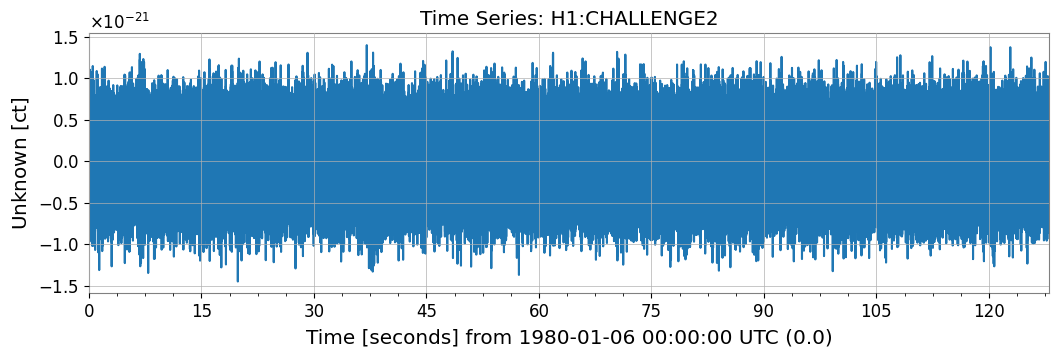

In [15]:
plot = data.plot()
plot.gca().set_title("Time Series: H1:CHALLENGE2")
plot.show()

In [18]:
import numpy as np

# Find time of maximum strain amplitude
peak_time = data.times.value[np.argmax(abs(data.value))]
print(f"Estimated merger time: {peak_time:.3f} seconds")


Estimated merger time: 19.856 seconds


In [21]:
from gwpy.timeseries import TimeSeries
from pycbc.types import TimeSeries as PTimeSeries
from pycbc.filter import match, matched_filter
from pycbc.psd import welch
from pycbc.waveform import get_td_waveform
import numpy as np

# Load strain data from challenge2.gwf
gwpy_data = TimeSeries.read("challenge2.gwf", channel="H1:CHALLENGE2")

# Convert to PyCBC TimeSeries for filtering
strain = PTimeSeries(gwpy_data.value, delta_t=1.0 / gwpy_data.sample_rate.value)


In [59]:
# Estimate the noise power spectral density
# Calculate the number of segments that fit evenly
# Ensure seg_len and num_segments divide the data evenly
seg_len = int(4 * strain.sample_rate)  # Use a power of 2 for efficiency

# Calculate the number of segments that fit evenly into the data
num_segments = int(len(strain) / (seg_len / 2)) - 1  # Default seg_stride is seg_len / 2

# Now seg_len and num_segments should be compatible
# with the default seg_stride (seg_len / 2) and ensure all data points are used.
psd = welch(strain, seg_len=seg_len, avg_method='median', num_segments=num_segments)
psd = interpolate(psd, strain.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * strain.sample_rate))

In [60]:
# Generate the expected gravitational waveform
hp, _ = get_td_waveform(approximant="SEOBNRv4_opt",
                        mass1=30, mass2=30,
                        delta_t=strain.delta_t,
                        f_lower=20)


In [61]:
# Resize template to match data length
hp.resize(len(strain))

In [62]:
# Apply matched filter
snr = matched_filter(hp, strain, psd=psd, low_frequency_cutoff=20.0)

# Get peak SNR and time
peak_snr = abs(snr).numpy().max()
peak_time = snr.sample_times[np.argmax(abs(snr))]
print(f"Matched filter SNR: {peak_snr:.2f}")
print(f"Time of peak SNR: {peak_time}")

Matched filter SNR: 425.96
Time of peak SNR: 7.738769531250001


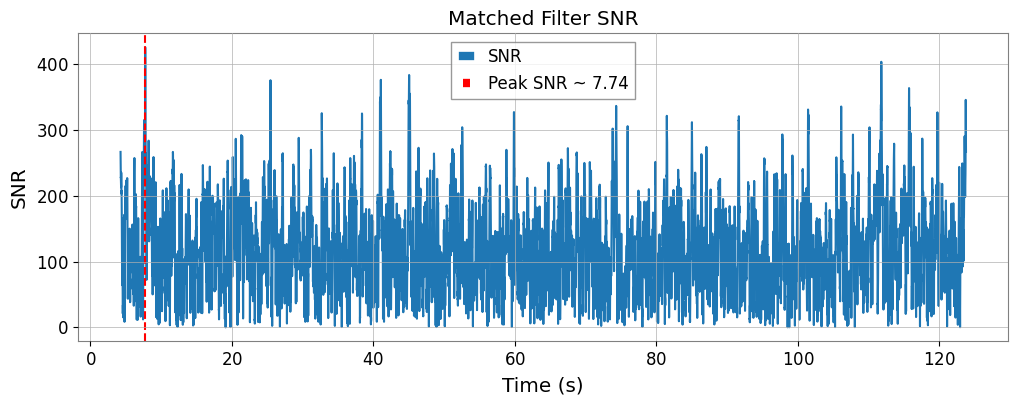

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(snr.sample_times, abs(snr), label="SNR")
plt.axvline(peak_time, color='red', linestyle='--', label=f"Peak SNR ~ {peak_time:.2f}")
plt.xlabel("Time (s)")
plt.ylabel("SNR")
plt.title("Matched Filter SNR")
plt.legend()
plt.grid(True)
plt.show()

Sample rate: 4096.0 Hz
Duration: 4096.0 s s


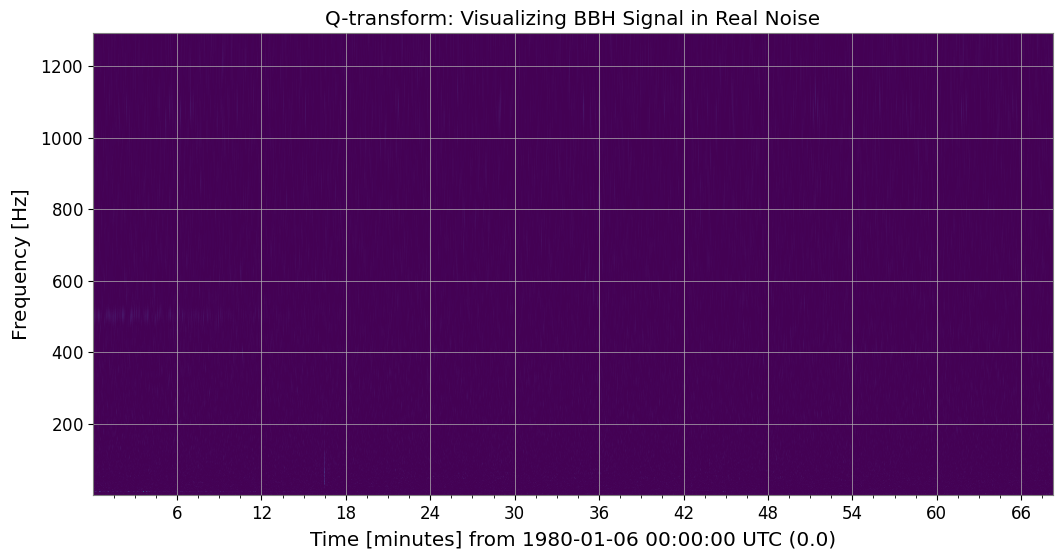

In [71]:
from astropy import units as u

strain = TimeSeries.read("challenge3.gwf", channel="H1:CHALLENGE3")
strain_pycbc = PTimeSeries(strain.value, delta_t=1.0 / strain.sample_rate.value)

print(f"Sample rate: {strain.sample_rate.value} Hz")
print(f"Duration: {strain.duration} s")

# Convert the integer values to quantities with units of seconds
outseg = (strain.t0 + 1 * u.s, strain.t0 + strain.duration - 1 * u.s)

outseg_seconds = (outseg[0].value, outseg[1].value)

# Use the modified outseg_seconds for q_transform
strain.q_transform(outseg=outseg_seconds).plot()
plt.title("Q-transform: Visualizing BBH Signal in Real Noise")
plt.show()

In [66]:
hp, _ = get_td_waveform(approximant="SEOBNRv4_opt",
                        mass1=10, mass2=10,
                        delta_t=strain_pycbc.delta_t,
                        f_lower=20)

In [67]:
hp = hp.crop(2, 2)
hp.resize(len(strain_pycbc))

In [76]:
seg_len = int(2 * strain_pycbc.sample_rate)  # Reduced from 4 to 2 seconds
# Calculate segment duration in seconds
segment_duration = seg_len / strain_pycbc.sample_rate

psd = strain_pycbc.psd(segment_duration=segment_duration,  # Use segment_duration instead of seg_len
                      # optional: modify seg_stride for finer segments
                      #seg_stride=int(seg_len / 4),
                      avg_method='median')
psd = interpolate(psd, strain_pycbc.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * strain_pycbc.sample_rate))

In [78]:
# 5. Find peak SNR value and corresponding time
peak_snr = abs(snr).numpy().max()
peak_time = snr.sample_times[np.argmax(abs(snr))]

print(f"Merger Time ≈ {peak_time:.2f} seconds from start of segment")
print(f"Matched Filter SNR ≈ {peak_snr:.2f}")

Merger Time ≈ 7.74 seconds from start of segment
Matched Filter SNR ≈ 425.96


In [79]:
!pip install gwpy pycbc bilby[gw] --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.9/983.9 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.2/108.2 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 60.3 MB/s eta 0:00:00


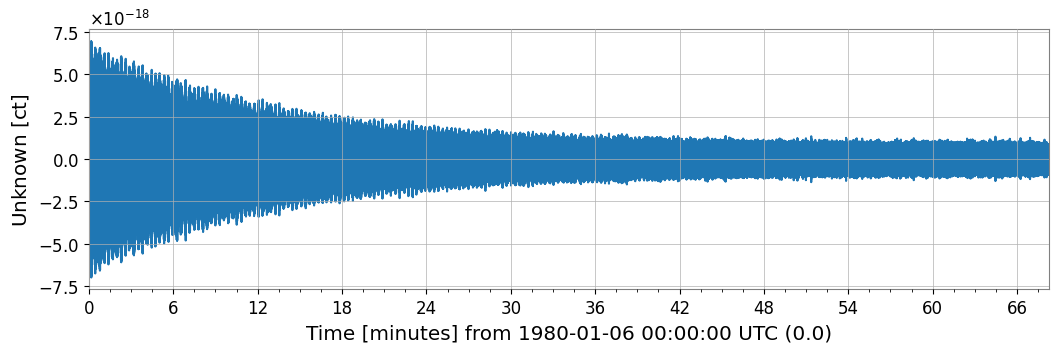

/usr/local/lib/python3.11/dist-packages/gwpy/plot/axes.py:194: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  super().draw(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


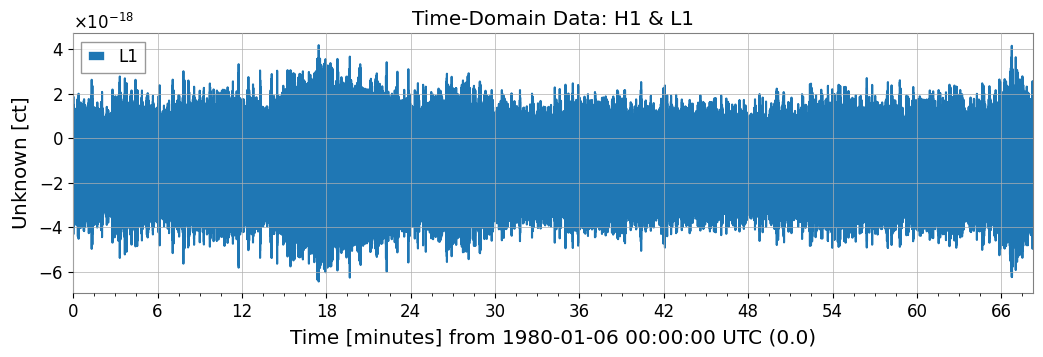

In [80]:
from gwpy.timeseries import TimeSeries
import matplotlib.pyplot as plt

# Load both detectors
h1 = TimeSeries.read("challenge3.gwf", channel="H1:CHALLENGE3")
l1 = TimeSeries.read("challenge3.gwf", channel="L1:CHALLENGE3")

# Plot both for visual inspection
h1.plot(label='H1')
l1.plot(label='L1')
plt.legend()
plt.title("Time-Domain Data: H1 & L1")
plt.show()


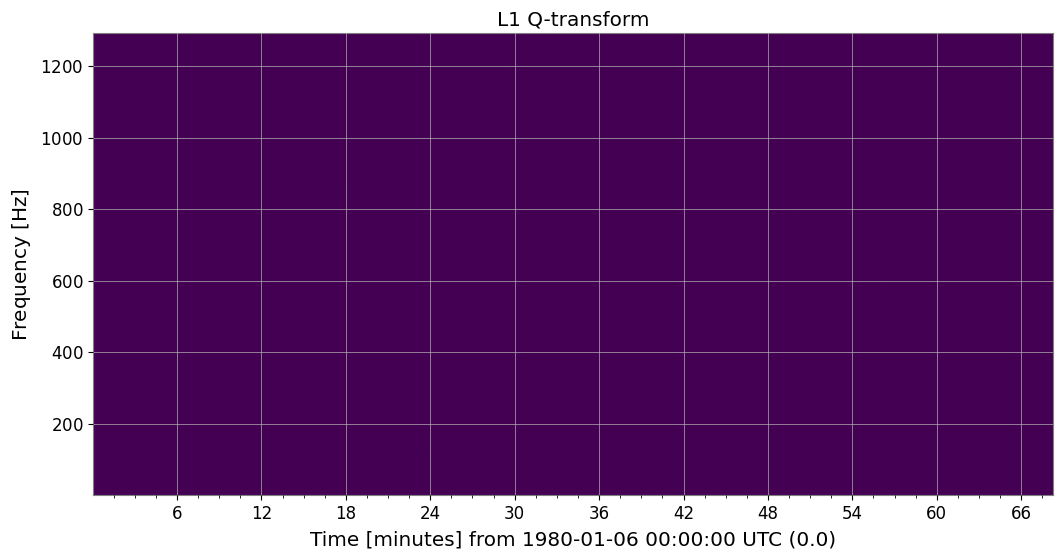

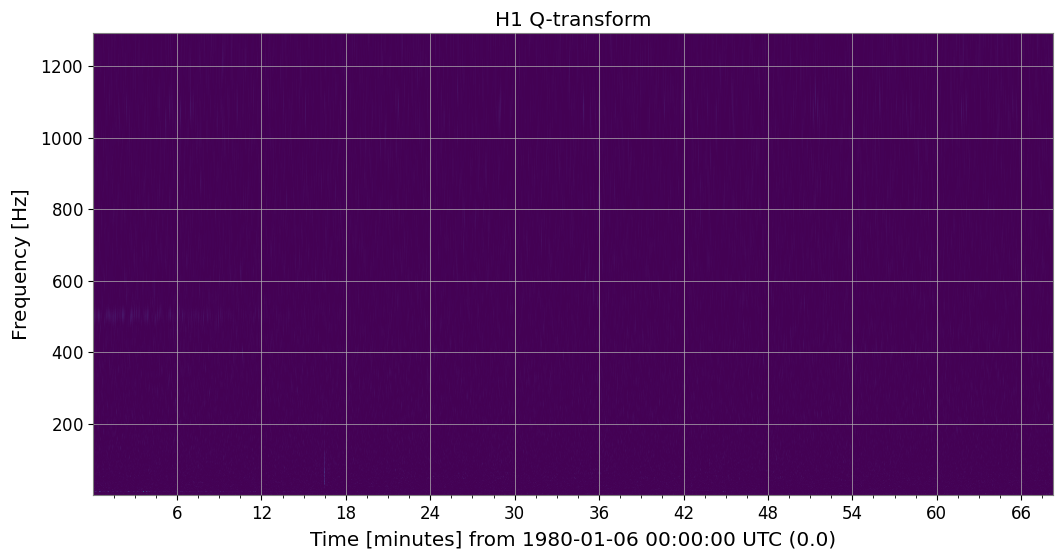

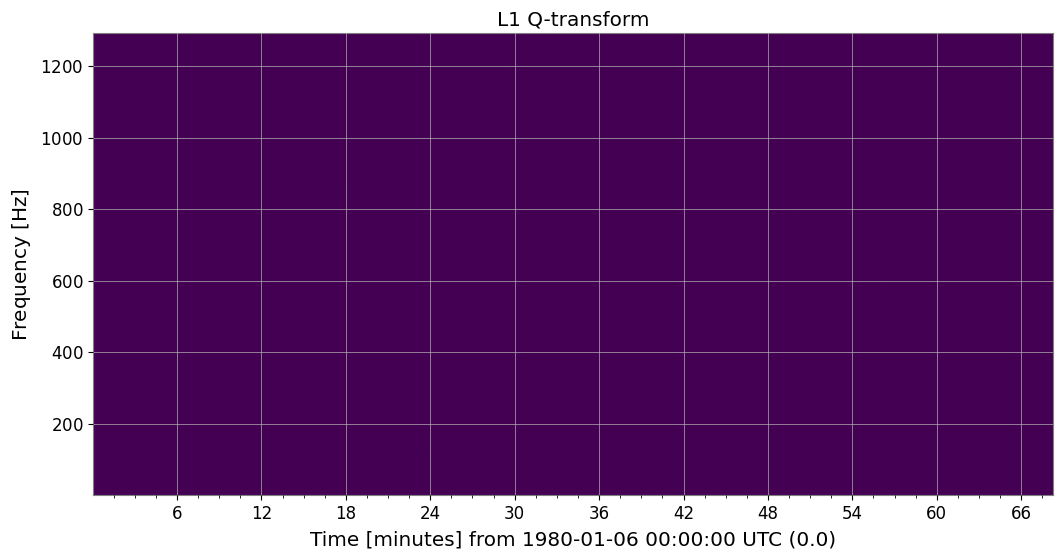

In [84]:
from astropy import units as u  # Import units

# Focus on the cleanest 1-second segment
hq = h1.q_transform(outseg=(h1.t0.value + 1, (h1.t0 + h1.duration - 1 * u.s).value))  # Access .value for floats and convert 1 to seconds
lq = l1.q_transform(outseg=(l1.t0.value + 1, (l1.t0 + l1.duration - 1 * u.s).value))  # Access .value for floats and convert 1 to seconds

hq.plot(title="H1 Q-transform")
lq.plot(title="L1 Q-transform")

In [95]:
from pycbc.waveform import get_td_waveform
from pycbc.psd import welch, interpolate, inverse_spectrum_truncation
from pycbc.filter import matched_filter
from pycbc.types import TimeSeries as PTimeSeries # Import PyCBC TimeSeries
import numpy as np

# Estimate PSD using Welch method
# Convert gwpy.timeseries.TimeSeries to pycbc.types.TimeSeries
h1_pycbc = PTimeSeries(h1.value, delta_t=h1.dt.value)
psd = welch(h1_pycbc, seg_len=4, avg_method='median') # Use h1_pycbc
psd = interpolate(psd, h1_pycbc.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * h1_pycbc.sample_rate))

# Define template (adjust m1/m2 if you loop)
hp, _ = get_td_waveform(approximant="SEOBNRv4_opt",
                        mass1=30, mass2=30, delta_t=h1_pycbc.delta_t, f_lower=20) # Use h1_pycbc

In [103]:
hp.resize(len(h1_pycbc))

snr = matched_filter(hp, h1_pycbc, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4, 4)  # trim edges

# Identify peaks in SNR above a threshold
snr_threshold = 5.0
peak_indices = np.where(snr.numpy() > snr_threshold)[0]
peak_times = snr.sample_times[peak_indices]

# Remove close duplicates
from scipy.signal import find_peaks

peaks, _ = find_peaks(snr.numpy(), height=snr_threshold, distance=512)
detected_events = snr.sample_times[peaks]

# Print info
for peak in detected_events:
    snr_val = snr[peak]
    print(f"Candidate Detected at t = {peak:.2f} s | SNR = {snr_val:.2f}")


/usr/local/lib/python3.11/dist-packages/scipy/signal/_peak_finding.py:266: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)


In [104]:
# Example placeholder estimate (assume symmetric 30Msun, adjust in loop for more precision)
estimated_m1, estimated_m2 = 30, 30

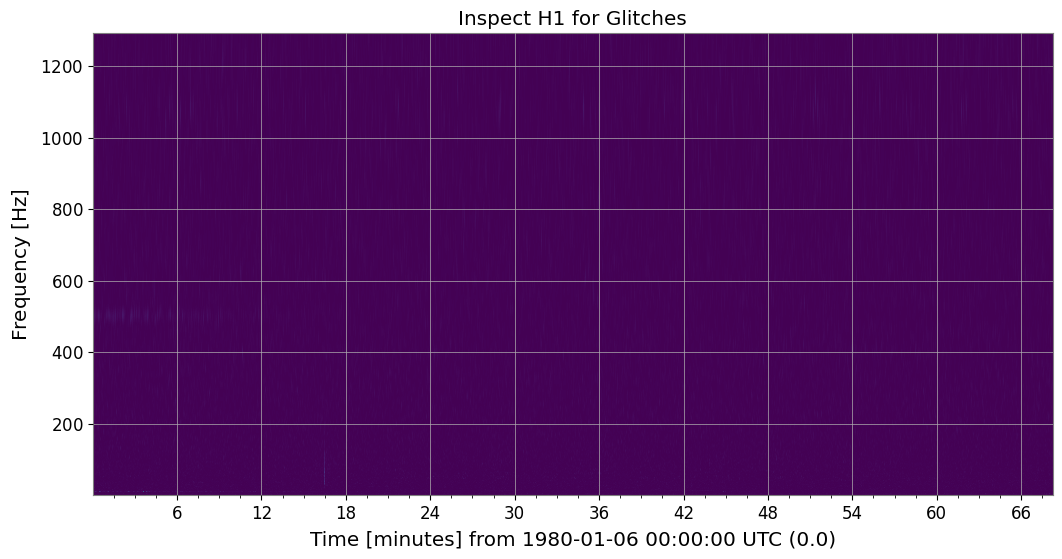

In [105]:
hq.plot(title="Inspect H1 for Glitches").show()
# If you see any strange patterns not matching BBH chirps, note their time here:
# e.g., print("⚠️ Glitch-like feature at t = 15.4 s")

In [122]:
 from pycbc.filter import matched_filter
from pycbc.types import TimeSeries
from pycbc.waveform import get_td_waveform

best_snr = 0
best_time = 0
best_m1, best_m2 = 0, 0

for m in range(10, 51, 2):  # Try equal masses from 10 to 50 Msun
    hp, _ = get_td_waveform(approximant="SEOBNRv4_opt",
                            mass1=m, mass2=m,
                            delta_t=strain.dt.value,
                            f_lower=20)


    hp.resize(len(h1_pycbc))
    snr = matched_filter(hp, h1_pycbc, psd=psd, low_frequency_cutoff=20)
    snr = snr.crop(4, 4)  # trim edges

    peak = abs(snr).numpy().argmax()
    snr_val = abs(snr[peak])

    if snr_val > best_snr:
        best_snr = snr_val
        best_time = snr.sample_times[peak]
        best_m1, best_m2 = m, m

print(f"Merger Time: {best_time - strain.t0.value:.2f} s (from start)")
print(f"SNR: {best_snr:.2f}")
print(f"Masses: m1 = m2 = {best_m1} Msun")

Merger Time: 4091.55 s (from start)
SNR: 0.31
Masses: m1 = m2 = 10 Msun


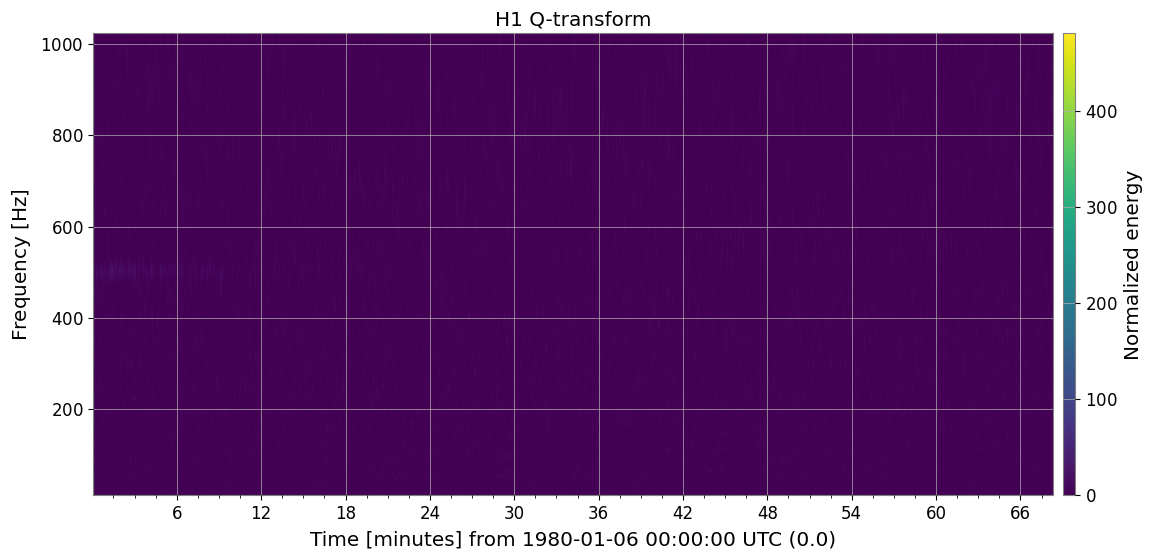

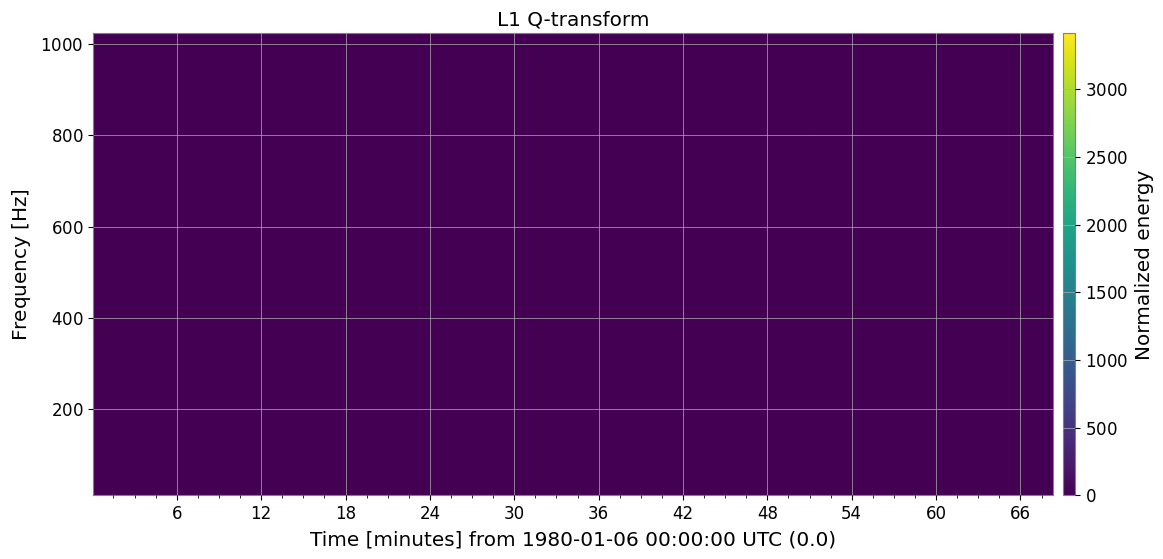

In [123]:
h1_q = h1.q_transform(outseg=(h1.times.value[0] + 2, h1.times.value[-1] - 2))
l1_q = l1.q_transform(outseg=(l1.times.value[0] + 2, l1.times.value[-1] - 2))

h1_q_plot = h1_q.plot()
h1_q_plot.colorbar(label="Normalized energy")
h1_q_plot.gca().set_ylim(10, 1024)
h1_q_plot.gca().set_title("H1 Q-transform")
plt.show()

l1_q_plot = l1_q.plot()
l1_q_plot.colorbar(label="Normalized energy")
l1_q_plot.gca().set_ylim(10, 1024)
l1_q_plot.gca().set_title("L1 Q-transform")
plt.show()


In [125]:
# Convert Q-transform to peak energies and times
h1_energy = h1_q.value
l1_energy = l1_q.value

# Thresholding: detect times where energy exceeds a value (e.g. 25x median energy)
h1_threshold = 25 * np.median(h1_energy)
l1_threshold = 25 * np.median(l1_energy)

h1_glitch_indices = np.where(h1_energy > h1_threshold)
l1_glitch_indices = np.where(l1_energy > l1_threshold)

# Extract times
h1_glitch_times = h1_q.times[h1_glitch_indices[0]]
l1_glitch_times = l1_q.times[l1_glitch_indices[0]]

# Remove duplicates within a small time window (e.g. 0.5s)
def deduplicate(times, window=0.5):
    deduped = []
    for t in sorted(times):
        if not deduped or t - deduped[-1] > window:
            deduped.append(t)
    return deduped

h1_glitch_times_clean = deduplicate(h1_glitch_times.value)
l1_glitch_times_clean = deduplicate(l1_glitch_times.value)

# Print results
print("Detected Glitch Times (H1):")
for t in h1_glitch_times_clean:
    print(f"- {t:.2f} s")

print("\n Detected Glitch Times (L1):")
for t in l1_glitch_times_clean:
    print(f"- {t:.2f} s")


Detected Glitch Times (H1):
- 2.00 s
- 6.09 s
- 10.18 s
- 14.28 s
- 18.37 s
- 22.46 s
- 26.55 s
- 30.64 s
- 34.74 s
- 38.83 s
- 42.92 s
- 47.01 s
- 51.10 s
- 55.20 s
- 59.29 s
- 63.38 s
- 67.47 s
- 71.56 s
- 75.66 s
- 79.75 s
- 83.84 s
- 87.93 s
- 92.02 s
- 96.12 s
- 100.21 s
- 104.30 s
- 108.39 s
- 112.48 s
- 116.58 s
- 120.67 s
- 124.76 s
- 132.94 s
- 137.04 s
- 141.13 s
- 145.22 s
- 149.31 s
- 153.40 s
- 157.50 s
- 161.59 s
- 169.77 s
- 173.86 s
- 177.96 s
- 182.05 s
- 186.14 s
- 190.23 s
- 194.32 s
- 198.42 s
- 206.60 s
- 210.69 s
- 214.78 s
- 218.88 s
- 222.97 s
- 227.06 s
- 231.15 s
- 235.24 s
- 243.43 s
- 247.52 s
- 251.61 s
- 259.80 s
- 263.89 s
- 267.98 s
- 272.07 s
- 280.26 s
- 284.35 s
- 288.44 s
- 296.62 s
- 300.72 s
- 304.81 s
- 308.90 s
- 317.08 s
- 321.18 s
- 325.27 s
- 333.45 s
- 337.54 s
- 341.64 s
- 345.73 s
- 353.91 s
- 358.00 s
- 362.10 s
- 370.28 s
- 374.37 s
- 378.46 s
- 382.56 s
- 390.74 s
- 394.83 s
- 398.92 s
- 407.11 s
- 411.20 s
- 415.29 s
- 419.38 s
- 427.57